In [59]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to /Users/sunyamare/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sunyamare/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [60]:
random_state = 8

In [61]:
def get_df(dataset_name, dropna=True, fillna_value=''):
    df = pd.read_csv(f"data/{dataset_name}.csv")
    
    if dropna:
        df.dropna(inplace=True)
    else:
        df.fillna(fillna_value, inplace=True)

    df.drop(['ID'], axis=1, inplace=True) # remove useless data

    df['Rating'] = df['Rating'] - 1 # make y 0-indexed
    return df

In [62]:
df_train = get_df('train', dropna=True)
df_valid = get_df('valid', dropna=False)
df_test = get_df('test', dropna=False)

In [63]:
df_train.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",4,1,0,General Petite,Bottoms,Pants
3,847,47,Flattering shirt,This shirt is very flattering to all due to th...,4,1,6,General,Tops,Blouses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,4,1,1,General Petite,Tops,Knits


In [64]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15763 entries, 2 to 18789
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              15763 non-null  int64 
 1   Age                      15763 non-null  int64 
 2   Title                    15763 non-null  object
 3   Review Text              15763 non-null  object
 4   Rating                   15763 non-null  int64 
 5   Recommended IND          15763 non-null  int64 
 6   Positive Feedback Count  15763 non-null  int64 
 7   Division Name            15763 non-null  object
 8   Department Name          15763 non-null  object
 9   Class Name               15763 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.3+ MB


<AxesSubplot: >

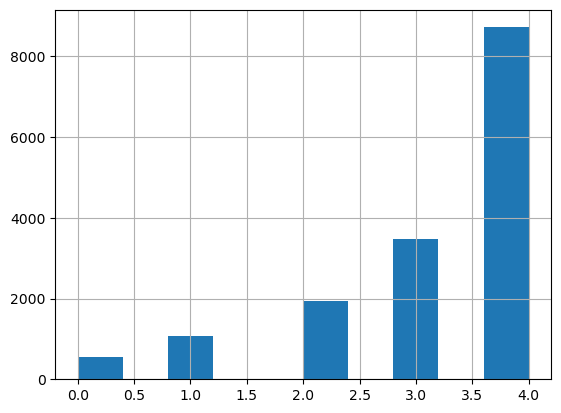

In [65]:
df_train['Rating'].hist()

In [66]:
tokenizer = TweetTokenizer()
stop_words = set(stopwords.words("english"))
keep_stop_words = ['not', 'no', 'against', 'above', 'below']
for word in keep_stop_words:
    stop_words.remove(word)
lemmatizer = WordNetLemmatizer()

def tokenize_text(text: str):
    if (not isinstance(text, str)):
        raise ValueError(f"The text {text} isn't a string!")

    # Change 't to 'not'
    text = re.sub(r"n\'t", " not", text)
    # Remove punctuation except '!'
    text = re.sub(r"[^\w\s!]", "", text)
    # Remove numbers
    text = re.sub(r"[^\D\s!]", "", text)
    
    text = text.lower()

    word_tokens = tokenizer.tokenize(text)

    filtered_words_tokens = [w for w in word_tokens if not w in stop_words]

    lemmatized_text = [lemmatizer.lemmatize(w) for w in filtered_words_tokens]
    
    return ' '.join(lemmatized_text)

In [67]:
def get_tokenized_X(X):
    return [tokenize_text(text) for text in X]

In [68]:
def get_tfidf_vectorizer(X_train, ngram_range=(1, 1), max_features=None):
    # settings inspired by https://www.linkedin.com/pulse/another-twitter-sentiment-analysis-python-part-5-tfidf-ricky-kim/
    # TODO consider options: max_df=0.9, min_df=2
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    tfidf_vectorizer.fit(get_tokenized_X(X_train))

    return tfidf_vectorizer

In [69]:
def get_count_vectorizer(X_train, ngram_range=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngram_range)
    count_vectorizer.fit(get_tokenized_X(X_train))

    return count_vectorizer

In [70]:
def get_vectorized_X(X, vectorizer):
    tokenized_X = get_tokenized_X(X)

    vectorized_X = vectorizer.transform(tokenized_X)

    return vectorized_X.toarray()

In [71]:
def get_df_tokenizer_applied(df, columns):
    df = df.copy()
    for column in columns:
        print(f"Applying tokenize_text() to column {column}")
        df[column] = df[column].apply(tokenize_text)
    return df

In [72]:
df_train_pp = get_df_tokenizer_applied(df_train, ['Title', 'Review Text'])
df_valid_pp = get_df_tokenizer_applied(df_valid, ['Title', 'Review Text'])
df_test_pp = get_df_tokenizer_applied(df_test, ['Title', 'Review Text'])

Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text
Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text
Applying tokenize_text() to column Title
Applying tokenize_text() to column Review Text


In [73]:
df_train_pp.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1049,50,favorite buy !,love love love jumpsuit fun flirty fabulous ! ...,4,1,0,General Petite,Bottoms,Pants
3,847,47,flattering shirt,shirt flattering due adjustable front tie perf...,4,1,6,General,Tops,Blouses
4,858,39,cagrcoal shimmer fun,aded basket hte last mintue see would look lik...,4,1,1,General Petite,Tops,Knits


---

In [74]:
def get_ohe_for_df_column(df_column):
    ohe_column = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_column.fit(df_column.to_numpy().reshape(-1, 1))
    return ohe_column

In [75]:
ohe_divisionname = get_ohe_for_df_column(df_train_pp['Division Name'])
ohe_departmentname = get_ohe_for_df_column(df_train_pp['Department Name'])
ohe_classname = get_ohe_for_df_column(df_train_pp['Class Name'])

In [76]:
def get_df_with_ohe_column(df, ohe_column_name, ohe):
    ohe_column_encoded = ohe.transform(df[ohe_column_name].to_numpy().reshape(-1, 1))

    ohe_df = pd.DataFrame(ohe_column_encoded.tolist(), columns=ohe.get_feature_names_out(input_features=[ohe_column_name]), dtype=int)
    # reset_index() is necessary here: https://stackoverflow.com/questions/50368145/pandas-concat-increases-number-of-rows
    # drop=True as well: https://stackoverflow.com/questions/12203901/pandas-crashes-on-repeated-dataframe-reset-index
    new_df = pd.concat([df.reset_index(drop=True), ohe_df], axis=1).drop([ohe_column_name], axis=1)

    return new_df

In [77]:
def get_df_with_ohe_columns(df):
    df = get_df_with_ohe_column(df, 'Division Name', ohe_divisionname)
    df = get_df_with_ohe_column(df, 'Department Name', ohe_departmentname)
    df = get_df_with_ohe_column(df, 'Class Name', ohe_classname)
    
    return df

In [78]:
do_categorical_value_ohe = True

if (do_categorical_value_ohe):
    df_train_wo_cat = get_df_with_ohe_columns(df_train_pp)
    df_valid_wo_cat = get_df_with_ohe_columns(df_valid_pp)
    df_test_wo_cat = get_df_with_ohe_columns(df_test_pp)
else:
    df_train_wo_cat = df_train_pp.drop(['Division Name', 'Department Name', 'Class Name'], axis=1)
    df_valid_wo_cat = df_valid_pp.drop(['Division Name', 'Department Name', 'Class Name'], axis=1)
    df_test_wo_cat = df_test_pp.drop(['Division Name', 'Department Name', 'Class Name'], axis=1)

df_train_wo_cat.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,...,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,1049,50,favorite buy !,love love love jumpsuit fun flirty fabulous ! ...,4,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,847,47,flattering shirt,shirt flattering due adjustable front tie perf...,4,1,6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,858,39,cagrcoal shimmer fun,aded basket hte last mintue see would look lik...,4,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


---

In [79]:
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3)) # 0.618
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 10000) # 0.622
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 7000) # 0.619
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 4000) # 0.617
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 1000) # 0.615
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 15000) # 0.617
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 20000) # 0.617
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 8500) # 0.623
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 9000) # 0.622
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 8000) # 0.623
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 7500) # 0.622
# title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 8250) # 0.622
title_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Title'], (1, 3), 8000)

# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 8000) # 0.636
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 5000) # 0.632
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 3000) # 0.635
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 1000) # 0.635
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 500) # 0.627
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 10000) # 0.639
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 15000) # 0.640
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 20000) # 0.639
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 25000) # 0.639
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 17500) # 0.640
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 12500) # 0.641
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 14000) # 0.642
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 14500) # 0.640
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 13000) # 0.643
# reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 13500) # 0.640
reviewtext_vectorizer = get_tfidf_vectorizer(df_train_wo_cat['Review Text'], (1, 2), 13000)

In [80]:
X_train_title = get_vectorized_X(df_train_wo_cat['Title'], title_vectorizer)
X_valid_title = get_vectorized_X(df_valid_wo_cat['Title'], title_vectorizer)

X_train_reviewtext = get_vectorized_X(df_train_wo_cat['Review Text'], reviewtext_vectorizer)
X_valid_reviewtext = get_vectorized_X(df_valid_wo_cat['Review Text'], reviewtext_vectorizer)

In [81]:
y_train_title = df_train_wo_cat['Rating'].tolist()
y_valid_title = df_valid_wo_cat['Rating'].tolist()

y_train_reviewtext = df_train_wo_cat['Rating'].tolist()
y_valid_reviewtext = df_valid_wo_cat['Rating'].tolist()

In [82]:
print(len(X_train_title), len(y_train_title))
print(len(X_valid_title), len(y_valid_title))

15763 15763
2348 2348


In [83]:
# nb_title = MultinomialNB() # Accuracy:  0.5936967632027257
# nb_title.fit(X_train_title, y_train_title)
# y_pred_title = nb_title.predict(X_valid_title)
# accuracy = accuracy_score(y_valid_title, y_pred_title)
# print("Naive Bayes 'Title Sentiment' Accuracy: ", accuracy)

In [84]:
logreg_title = LogisticRegression(random_state=random_state, solver="saga", max_iter=200) # Accuracy:  0.618824531516184
logreg_title.fit(X_train_title, y_train_title)
y_pred_title = logreg_title.predict(X_valid_title)
accuracy = accuracy_score(y_valid_title, y_pred_title)
print("Logistic Regression 'Title Sentiment' Accuracy: ", accuracy)

Logistic Regression 'Title Sentiment' Accuracy:  0.623083475298126


In [85]:
# nb_reviewtext = MultinomialNB() # Accuracy:  0.608
# nb_reviewtext.fit(X_train_reviewtext, y_train_reviewtext)
# y_pred_reviewtext = nb_reviewtext.predict(X_valid_reviewtext)
# accuracy = accuracy_score(y_valid_reviewtext, y_pred_reviewtext)
# print("Naive Bayes 'Review Text' Accuracy: ", accuracy)

In [86]:
# xgb_reviewtext = XGBClassifier(random_state=random_state, objective='multi:softmax') # Accuracy:  0.615 (3.5m runtime) with 8000 features
# xgb_reviewtext.fit(X_train_reviewtext, y_train_reviewtext)
# y_pred_reviewtext = xgb_reviewtext.predict(X_valid_reviewtext)
# accuracy = accuracy_score(y_valid_reviewtext, y_pred_reviewtext)
# print("XGBoost 'Review Text Sentiment' Accuracy: ", accuracy)

In [87]:
logreg_reviewtext = LogisticRegression(random_state=random_state, solver="saga", max_iter=200) # Accuracy:  0.618824531516184
logreg_reviewtext.fit(X_train_reviewtext, y_train_reviewtext)
y_pred_reviewtext = logreg_reviewtext.predict(X_valid_reviewtext)
accuracy = accuracy_score(y_valid_reviewtext, y_pred_reviewtext)
print("Logistic Regression 'Review Text Sentiment' Accuracy: ", accuracy)

Logistic Regression 'Review Text Sentiment' Accuracy:  0.6431005110732538


In [88]:
X_valid_reviewtext.shape # (2348, 212416)

(2348, 13000)

---

In [89]:
def preprocess_df(df: pd.DataFrame):
    vectorized_title = title_vectorizer.transform(df['Title']).toarray()
    df['Title Sentiment'] = logreg_title.predict(vectorized_title)
    # df = pd.DataFrame(vectorized_title, index=df.index)

    vectorized_reviewtext = reviewtext_vectorizer.transform(df['Review Text']).toarray()
    df['Review Text Sentiment'] = logreg_reviewtext.predict(vectorized_reviewtext)
    # df = pd.DataFrame(vectorized_reviewtext, index=df.index)

    # df_with_title_and_text = pd.concat([df, title_df, text_df], axis=1)

    df.drop(['Title'], axis=1, inplace=True)
    df.drop(['Review Text'], axis=1, inplace=True)

    return df

In [90]:
print('preprocessing train data')
df_train_final = preprocess_df(df_train_wo_cat)
print('preprocessing valid data')
df_valid_final = preprocess_df(df_valid_wo_cat)
# print('preprocessing test data')
# df_test_final = preprocess_df(df_test_wo_cat)

preprocessing train data
preprocessing valid data


In [91]:
df_train_final.head(3)

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count,Division Name_General,Division Name_General Petite,Division Name_Initmates,Department Name_Bottoms,Department Name_Dresses,...,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,Title Sentiment,Review Text Sentiment
0,1049,50,4,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,4,4
1,847,47,4,1,6,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4
2,858,39,4,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,4,4


In [92]:
y_train = df_train_final['Rating'].values
y_valid = df_valid_final['Rating'].values

In [93]:
df_train_final.drop(['Rating'], axis=1, inplace=True)
X_train = df_train_final.values
df_valid_final.drop(['Rating'], axis=1, inplace=True)
X_valid = df_valid_final.values

In [94]:
# rf_tab = RandomForestClassifier(random_state=random_state, n_estimators=1000)
# rf_tab.fit(X_train, y_train)
# y_preds = rf_tab.predict(X_valid)
# rf_tab_accuracy = accuracy_score(y_valid, y_preds)
# print(f"Random Forest tabular accuracy: {rf_tab_accuracy}")

In [96]:
# gbt_tab = GradientBoostingClassifier(random_state=random_state, n_estimators=1000)
# gbt_tab.fit(X_train, y_train)
# y_preds = gbt_tab.predict(X_valid)
# gbt_tab_accuracy = accuracy_score(y_valid, y_preds)
# print(f"Gradient Boosting tabular accuracy: {gbt_tab_accuracy}")

In [102]:
# logreg_tab = LogisticRegression(random_state=random_state, solver="saga", max_iter=20000) # accuracy: 0.662
logreg_tab = LogisticRegression(random_state=random_state, solver="lbfgs", max_iter=20000) # accuracy: 0.676
logreg_tab.fit(X_train, y_train)
y_preds = logreg_tab.predict(X_valid)
logreg_tab_accuracy = accuracy_score(y_valid, y_preds)
print(f"Logistic Regression tabular accuracy: {logreg_tab_accuracy}")

Logistic Regression tabular accuracy: 0.6767461669505963


In [97]:
bst_tab = XGBClassifier(random_state=random_state, n_estimators=9, max_depth=2, learning_rate=.9, objective='multi:softmax')
bst_tab.fit(X_train, y_train)
y_preds = bst_tab.predict(X_valid)
bst_tab_accuracy = accuracy_score(y_valid, y_preds)
print(f"XGBoost tabular accuracy: {bst_tab_accuracy}")

XGBoost tabular accuracy: 0.6643952299829642


In [98]:
bst_tab_hat = XGBClassifier(random_state=random_state, objective='multi:softmax')
bst_tab_hat.fit(X_train, y_train)
y_preds = bst_tab_hat.predict(X_valid)
bst_tab_hat_accuracy = accuracy_score(y_valid, y_preds)
print(f"XGBoost tabular accuracy: {bst_tab_hat_accuracy}")

XGBoost tabular accuracy: 0.6626916524701874
